# Encoding SAT: Orthogonal Hacked Phone

"Orthogonal Hacked Phone" is a revisited version of the childish game "Chinese Whispers".

One player is the hacker and his goal is to intercept a secret message and modify it. All the other players has to find out the correct sequence for the trasnmission of the secret message to avoid the hacker and preserve the original secret.

The rules of the game are:
- The first player must decide a secret message
- Each player receives the message from a player, sees it only once, and then send it to the next player
- The hacker must intercept and modify the message hacking some connections between players
- The players win if the message returns to the first player unmodified
- The hacker wins if the message returns to the first player modified (hacked by himself)

<img src="./images/OHPlogo.png" alt="OHP logo" width="300"/>

## Modelling the game 

Suppose 5 players and 1 hacker are playing the game. We can represent all the connections between the players as a graph where the player are the vertices and the connections are the edges of the graph.

<img src="./images/OHPgraph.png" alt="OHP logo" width="500"/>

Suppose we also know which connections have been hacked by the hacker. 

In this case we can determine if the players have a chance to win the game or not.

We can represent the game with the same graph as before with 2 different type of edges:
- blue edges, the safe ones
- red edges, the hacked ones   

<img src="./images/OHPhacked1.png" alt="OHP logo" width="500"/>

Now we can remove the hacked edges to obtain a graph where the remaining edges are the only ones referred to a safe conncetion.

<img src="./images/OHPnohack1.png" alt="OHP logo" width="500"/>

At this point, the goal is to determine whether this graph has an Hamiltonian circuit or not. A Hamiltonian circuit (or cycle) in a graph is a cycle that starts at some vertex, visits every vertex of the graph exactly once, and then returns to the starting vertex.

Hamiltonian Circuit is a NP-complete problem. So, we can reduct it to SAT encoding it and determine if with this configuration there is a chance to wim the match.

The idea behind the encoding is the following:
- for $n$ vertices in the graph we need $n^2$ boolean variables
- the assignment of the variables indicates a possible cycle in the graph 

$$
v_{i,j} =
\begin{cases}
1 & \text{if player $i$ is in the position $j$ of the cycle}  \\
0 & \text{otherwise}
\end{cases}
$$

For example, the following cycle is a possible solution:


<img src="./images/OHPsolved1.png" alt="OHP logo" width="500"/>

This cycle is represented by a single assignment of the variables we have defined. In particular:
- $v_{L,1}$ is set to true beacause Lorenzo is the first player in the cycle
- $v_{G,2}$ is set to true beacause Gianfranco is the second player in the cycle
- $v_{A,3}$ is set to true beacause Alessandro is the third player in the cycle
- $v_{B,4}$ is set to true beacause Buno is the fourth player in the cycle
- $v_{O,5}$ is set to true beacause Ozalp is the fifth player in the cycle
- all the other variables are set to false

To encode the problem in a propositional formula we need sto define some constraint that model our problem and use them to create the formula.

Constraints:
1. exactly one player for each position
2. exactly one position for each player
3. consecutive players only if connected

To model this problem and solve it efficiently with SAT solving we can use Z3 in python.

In [ ]:
!pip install z3-solver

In [73]:
from z3 import *
from itertools import combinations

Define some useful constraints:
- at least one
- at most one
- exactly one

In [74]:
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return And([Not(And(i, j)) for i,j in combinations(bool_vars, 2)])

def exactly_one(bool_vars):
    return And(at_least_one(bool_vars), at_most_one(bool_vars))

Define a function to solve an instance.

In [86]:
def solve(players:list, safe_connections:list[tuple]):

    # Number of players 
    n = len(players)

    # Variables 
    v = [[Bool(f"v_{i}_{j}") for j in range(1,n+1)] for i in players]

    # Solver instance
    s = Solver()

    # Exactly one player for each position
    for i in range(n):
        s.add(exactly_one(v[i]))

    # Exactly one position for each player
    for j in range(n):
        s.add(exactly_one([v[i][j] for i in range(n)]))

    # Consecutive players only if connected
    for j in range(n):
        for k in range(n):
            if (players[j], players[k]) not in safe_connections:
                for i in range(n):
                    s.add(Or(Not(v[j][i]), Not(v[k][(i+1)%n])))

    if s.check() == sat:

        m = s.model()
        sol = [None]*n

        for i in range(n):
            for j in range(n):
                if is_true(m.evaluate(v[i][j])):
                    sol[j] = players[i]
        return sol
    else:
        return None

Define a function to plot the solution.

In [ ]:
!pip install --upgrade networkx
!pip install --upgrade matplotlib

In [77]:
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


def plot_solution(solution:list, players:list):

    if not solution:
        print("No solution found")
        return

    n = len(solution)

    G = nx.DiGraph()
    G.add_nodes_from(players)

    E_sol = [(solution[i], solution[(i+1)%n]) for i in range(n)]

    # Draw undirected edges from E (dark blue, no arrows)
    G_undirected = nx.Graph()
    G_undirected.add_nodes_from(players)
    G_undirected.add_edges_from(E)
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G_undirected, pos, edgelist=E, edge_color='darkblue', width=2)

    # Draw directed edges from E_sol (green, with arrows)
    G.add_edges_from(E_sol)
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=2000)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight="bold")
    nx.draw_networkx_edges(G, pos, edgelist=E_sol, edge_color='green', width=3)

    # Add edge labels for green edges
    edge_labels = {(E_sol[i][0], E_sol[i][1]): str(i+1) for i in range(n)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green', font_size=14)
    plt.axis('off')
    plt.show()

## Match 1 (SAT case)


Define the variables for the instance of the problem.

<img src="./images/OHPnohack1.png" alt="OHP logo" width="250"/>

In [79]:
# Number of players
players = ['A', 'B', 'G', 'L', 'O']

# Edges
edges1 = [
    ('A','B'), ('A','G'), ('A','L'), ('A','O'),
    ('B','A'), ('B','O'),
    ('G','A'), ('G','L'), ('G','O'),
    ('L','A'), ('L','G'), ('L','O'),
    ('O','A'), ('O','B'), ('O','G'), ('O','L'), 
]

Plot and solve the instance.

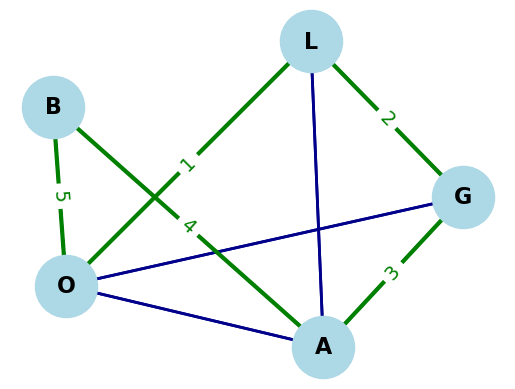

In [87]:
solution1 = solve(players=players, safe_connections=edges1)
plot_solution(solution=solution1, players=players)

## Match 2 (UNSAT case)

<img src="./images/OHPhacked2.png" alt="OHP logo" width="250"/>

<img src="./images/OHPnohack2.png" alt="OHP logo" width="250"/>

In [81]:
# Edges
edges2 = [
    ('A','B'), ('A','O'),
    ('B','A'), ('B','G'), ('B','L'), ('B','O'),
    ('G','B'), ('G','L'), 
    ('L','B'), ('L','G'),
    ('O','A'), ('O','B'),
]

In [88]:
solution2 = solve(players=players, safe_connections=edges2)
plot_solution(solution=solution2, players=players)

No solution found


## Large Instance Case

Define a function to generate a specified number of edges for a certain set of vertices.

In [90]:
import random

def generate_edges(players:list, num_edges:int) -> list[tuple]:
    edges_set = set()
    while len(edges_set) < num_edges:
        a, b = random.sample(players, 2)
        if (a, b) not in edges_set and (b, a) not in edges_set:
            edges_set.add((a, b))
            edges_set.add((b, a))

    large_edges = list(edges_set)
    return large_edges

Generate the edges for a larger instance of the problem and solve the problem.

In [91]:
large_players = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

num_edges = len(large_players) * 2 
large_edges = generate_edges(large_players, num_edges)

solution_large = solve(players=large_players, safe_connections=large_edges)
plot_solution(solution=solution_large, players=large_players)

No solution found


Retry to do the same thing changing the number of edges.

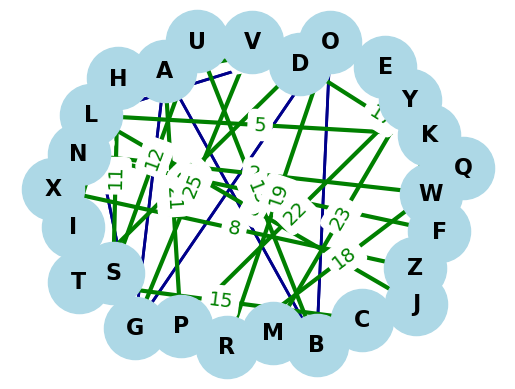

In [92]:
num_edges2 = len(large_players) * 4
large_edges2 = generate_edges(large_players, num_edges2)

solution_large2 = solve(players=large_players, safe_connections=large_edges2)
plot_solution(solution=solution_large2, players=large_players)